**Dependencies**

In [20]:
 !pip3 install swifter
 !pip3 install xgboost
 !pip3 install tqdm
 !pip3 install category_encoders
 !pip3 install joblib
 !pip3 install catboost
 !pip3 install scikit-plot

     |████████████████████████████████| 66.1MB 82kB/s 


## FUNCTIONS

In [21]:
################################ ALL IMPORTS ################################
import warnings
warnings.filterwarnings('ignore')

# FOR INIT
import pandas as pd
import numpy as np
import swifter

# FOR Visualization
import matplotlib.pyplot as plt

# For Date Engineering
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import itertools
import holidays

# For numeric Engineering
import time

# For Target Encoding
from category_encoders import TargetEncoder

# For feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, f_regression
from sklearn.ensemble import ExtraTreesClassifier

# POST PROCESS AND MACHINE LEARNING
from sklearn.preprocessing import PowerTransformer, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_absolute_error,r2_score
from xgboost import XGBClassifier,XGBRegressor
from tqdm import tqdm_notebook as tqdm
import scikitplot as skplt
import joblib

# For debugging
import pdb

**INPUT**

In [22]:
def importFile(path):

    print('#### RUNNING WAIT ####')
    
    # IF THE EXTENSION IS CSV
    def importCsv(path):
        
        print('We have a csv file')
        try:
            df = pd.read_csv(path,low_memory=False)
            if df.shape[1] == 1:
                df = pd.read_csv(path,low_memory=False,sep=';')                
            print('This file has {} columns and {} rows'.format(df.shape[1],df.shape[0]))
            return df       
            
        except FileNotFoundError:
            print('File not found, Check the name, path, spelling mistakes')
            error = True
            return None    
            
        except UnicodeDecodeError:
            try:
                enc = 'unicode_escape'
                df = pd.read_csv(path,encoding=enc,low_memory=False)
                print('This file has {} columns and {} rows'.format(df.shape[1],df.shape[0]))
                return df
                
            except UnicodeDecodeError:
                try:
                    enc = 'ISO-8859-1'
                    df = pd.read_csv(path,encoding=enc,low_memory=False)
                    print('This file has {} columns and {} rows'.format(df.shape[1],df.shape[0]))
                    return df
                except:
                    pass
          
        except:
            try:
                df= pd.read_csv(path)
                separators= ["~","!","@","#","$","%","^","&","*",":","|","/",";"]     # all possible separators
                if len(df.columns)<=3 :                                               # if separator was "," we would have more than 1 columns 
                    cols = df.columns[0]
                    possibleSep = []   
                    for i in separators:                                    # checking all the separators present in column names
                        if i in cols:
                            possibleSep.append(i)
                        
                    for j in possibleSep:                                   # iterate through possible seprators till we get the correct one
                        df_sep = pd.read_csv(path,sep=j)
                        if len(df_sep.columns)>3:
                            print('This file has {} columns and {} rows'.format(df_sep.shape[1],df_sep.shape[0]))
                            return df_sep
            except:
                try:
                    if len(pd.read_csv(path,sep=None).columns)>3  :                   # for tab ie "\" tsv files
                        df = pd.read_csv(path,sep=None)
                        print('This file has {} columns and {} rows'.format(df.shape[1],df.shape[0]))
                        return df
                except:        
                    pass

    # IF THE EXTENSION IS JSON
    def importJSON(path):
        try:
            print('We have a JSON file')
            df = pd.read_json(path)
            print('This file has {} columns and {} rows'.format(df.shape[1],df.shape[0]))
            return df    
        except Exception:
            try:
                df = pd.read_json(path,lines=True)
                print('This file has {} columns and {} rows'.format(df.shape[1],df.shape[0]))
                return df
        
            except ValueError:
                print('File not found, Check the name, path, spelling mistakes')
                error = True
                return None

    def Excel_handler(dx):
        # to handel cases when some blank rows or other information above the data table gets assumed to be column name 
        if (len([col for col in dx.columns if 'Unnamed' in col]) > 0.5*dx.shape[1]  ):#Checking for unnamed columns 
            colNew = dx.loc[0].values.tolist()           # Getting the values in the first row of the dataframe into a list
            dx.columns = colNew                          #Making values stored in colNew as the new column names
            dx = dx.drop(labels=[0])                     #dropping the row whose values we made as the column names
            dx.reset_index(drop=True, inplace=True)      #resetting index to the normal pattern 0,1,2,3...
        else:
            return dx
            
        new_column_names=dx.columns.values.tolist() # Following three lines of code are for counting the number of null values in our new set of column names
        new_column_names=pd.DataFrame(new_column_names)
        null_value_sum=new_column_names.isnull().sum()[0]
        if null_value_sum<0.5*dx.shape[1]: # if count of null values are less than a certain ratio of total no of columns
            return dx
        while(null_value_sum>=0.5*dx.shape[1]): 
            colNew = dx.loc[0].values.tolist()
            dx.columns = colNew
            dx = dx.drop(labels=[0])
            dx.reset_index(drop=True, inplace=True)
            new_column_names=dx.columns.values.tolist() 
            new_column_names=pd.DataFrame(new_column_names)
            null_value_sum=new_column_names.isnull().sum()[0]
        return dx 

    # IF THE EXTENSION IS XL
    def importExcel(path):
        try:
            print('We have an Excel file')
            df = pd.read_excel(path, sheet_name=None)
            if len(df.keys())==1 :                               # checking if number of sheets is 1
                df = Excel_handler(df[list(df.keys())[0]])
                print('This file has {} columns and {} rows'.format(df.shape[1],df.shape[0]))
                return df
            else:                                                 # when more than 1 sheets, asking the user for data sheet name/number
                print("Following are the sheets in the Excel file:")
                for c in range(len(df.keys())):
                    print(str(c)+".",list(df.keys())[c])
                sheet = input("Type the sheet name:  ")
                keys = [x.lower() for x in list(df.keys())]
                try:
                    index = keys.index(sheet.lower())
                    df = Excel_handler(df[list(df.keys())[index]])
                    print('This sheet {} has {} columns and {} rows'.format(sheet,df.shape[1],df.shape[0]))
                    return df
                except:
                    print('Sheet not found, Check the name, path, spelling mistakes')
                    error = True
                    return None
        except FileNotFoundError:
            print('File not found, Check the name, path, spelling mistakes')
            error = True
            return None


    def importTable(path):
        try:
            print('We have General Table File')
            df = pd.read_table(path)
            if df.shape[1] == 1:
                df = pd.read_table(path,sep=',')
            print('This file has {} columns and {} rows'.format(df.shape[1],df.shape[0]))
            return df
        except FileNotFoundError:
            print('File not found, Check the name, path, spelling mistakes')
            error = True
            return None
            
            
    try:
        ext = path.split('.')[1].lower()    
        if ext == 'csv' or ext == 'tsv':
            df = importCsv(path)
            return df
        elif ext == 'json':
            df = importJSON(path)
            return df
        elif 'xl' in ext:
            df = importExcel(path)
            return df
        elif ext == 'data':
            df = importTable(path)
            return df
        else:
            print('File format not supported\n')
    except:
        print('Extension NOT FOUND!')

**GETTING TARGET**

In [23]:
def getTarget(columns):
  
    print('\nEnter \'quit\' to quit')
    target = input('What would you like to predict? : ').lower()
    if target == 'quit':
        return None                    
    elif target in columns:
        print('Target Spotted!')
        return target
    else:
        print('Target {} Not found in the data'.format(target))
        return None

**KEY**

In [24]:
def getKey(columns):
    print('\nEnter \'quit\' to quit')
    key = input('Enter the Key/Identification Column : ').lower()
    if key == 'quit':
        return None,False              
    elif key in columns.values:
        print('Key Spotted!')
        return key
    else:
        print('Key {} Not found in the data'.format(key))
        print('Preview can\'t be shown!!')
        return None

**USER SPECIFIED**

In [25]:
def removeUserSpecifiedIDs(df,successiveTarget=False):
    removed_cols = set()
    not_found_cols = set()
    if not successiveTarget:
        print('Would you like to remove any other ID,zip Code,Phone Numbers,UNIQUE lists, ')
        print('Or columns that have only one unique entry? If yes, enter the column names below ')
    else:
        print('Do you think you have Successive Targets based on the current target? If yes, enter the column names below ')
    print('in this format separated by commas: col1,col2,col3')
    cols = input().lower()
    if not cols:
        print('No Columns removed')
        return df
    else:
        try:
            columns = cols.split(',')
            for column in columns:
                if column in df.columns:
                    df.drop(column,axis=1,inplace=True)
                    removed_cols.add(column)
                else:
                    not_found_cols.add(column)
            if removed_cols:
                print('\n{} columns are removed as entered by the user'.format(len(removed_cols)))
            if not_found_cols:
                print('\n{}'.format(not_found_cols))
                print('These columns were not found, hence not removed')
            return df
        except:
            print('Invalid Entry of columns! No Columns removed')
            return df

**Identify Date Columns**

In [26]:
######################## ----------------- DATE IDENTIFICATION --------------------- ######################

# Global List of all months
months = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

def getDateColumns(df,withPossibilies=0):
    '''
    This method Identifies all columns with 'DATE' data by maximizing out the possibilities
    '''
    # First get all non-numerical Columns
    non_numeric_cols = df.select_dtypes('object')
    # This dictionary stores possibilities of a column containing 'DATES' based on the name of the column
    Possibility = {}
    for column in non_numeric_cols:
        if 'date' in column.lower():                  
            Possibility[column] = int(len(df)*0.1)
        else:
            Possibility[column] = 0
        for entry in df[column]:                                                    # ITERATE THROUGH EVERY ENTRY AND TRY SPLITTING THE VALUE AND INCREMENT/DECREMENT POSSIBILITY 
            try:                                                                      # USING EXCEPTION HANDLING
                if len(entry.split('/')) == 3 or len(entry.split('-')) == 3 or len(entry.split(':')) == 3:
                    Possibility[column] += 1
                    for month in months:
                        if month in entry.lower():
                            Possibility[column] += 1 
                else:
                    Possibility[column] -= 1
            except:
                Possibility[column] -= 1        
      # This contains the final DATE Columns
    DATE_COLUMNS = []
    for key,value in Possibility.items():             
        if value > 0.8 * len(df):                                                  # IF THE POSSIBILITY OF THE COLUMN IN GREATER THAN 1, THEN IT IS DEFINITELY A 'DATE COLUMN'
            DATE_COLUMNS.append(key)    
    if not withPossibilies:
        return DATE_COLUMNS
    else:
        return DATE_COLUMNS,Possibility

**Date Engineering**

In [27]:
def date_engineering(df):
    start = time.time()
    date_cols = df.columns
    print('\n\t Entering Date Engineering')
    df = df.swifter.apply(lambda x: pd.to_datetime(x,errors='coerce',infer_datetime_format=True))
    
    # creating separate month and year columns
    for i in date_cols:
        df[str(i)+"_month"] = df[str(i)].dt.month
        df[str(i)+"_year"] = df[str(i)].dt.year

    # create difference columns
    if (len(date_cols)>1) :
        for i in itertools.combinations(date_cols,2):
            df[str(i[0])+" - "+str(i[1])]=(df[i[0]]-df[i[1]]).dt.days
            
    # create most recent
    for i in date_cols:
        df[str(i)+"-most_recent"] = (max(df[str(i)])-df[str(i)]).dt.days
    
    print('\n\t #### RUNNING WAIT ####')

    # See Near Holiday or not 
    def nearHol(currentDate, us_hols, currentYear):
        new_list = []
        append = new_list.append
        for date, occasion in us_hols:
            if(date.year == currentYear):
                append(date)
        flag = 1
        for i in new_list:
            a = (currentDate.date()-i).days

            if abs(a)<=5:flag =1;break
            else:flag = 0
                
        return 0 if flag == 0 else 1
        
    for col in date_cols:
        #creating a unique list of all years corresponding to a column to minimise mapping
        us_hols = holidays.US(years=df[str(col)+'_year'].astype(int).unique(), expand= False) 
        #creating a new columns to check if a date falls near a holiday
        df[str(col)+'_Holiday'] = df.apply(lambda x: nearHol(x[col],us_hols.items(),x[str(col)+'_year']),axis=1) 
    
    end = time.time()
    print('\nDate Engineering Time Taken : {}'.format(end-start))
    print('\n\t #### DONE ####')
    return df.drop(date_cols,axis=1)

**Numeric Engineering**

In [28]:
# Numeric Engineering 1(To be tested)
#For converting allnumeric data in columns like currency remperature, numbers in numeric form etc.. into numeric form
def numeric_engineering(df):
    start = time.time()  
    
    def returnMoney(col):
        # Remove Commas from currencies
        try:
            return pd.to_numeric(col.str.replace(',',''))
        except:
            return col
        
    obj_columns= list(df.dtypes[df.dtypes == np.object].index)
    # print(f'object type columns are {obj_columns}') 
    print(f'\t\t stripping spaces, symbols, and lower casing all entries')
    df[obj_columns]=df[obj_columns].swifter.apply(lambda x: x.astype(str).str.strip(' %$€£¥').str.lower())
    print('done ...')
    print(f'\t\t Replacing empty and invalid strings')
    df[obj_columns]=df[obj_columns].replace(['-','n/a','na','nan','nil',np.inf,-np.inf],[np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan])
    print('done ...')
    print(f'\t\t Replacing commas if present in Currencies')
    df[obj_columns]=df[obj_columns].swifter.apply(lambda x:returnMoney(x))
    print('done ...')
    obj_columns= list(df.dtypes[df.dtypes == np.object].index)
    df1 = df[obj_columns].copy()
    print(f'\t\t Finding Numeric Columns')
    df1 = df1.swifter.apply(lambda x : pd.to_numeric(x,errors='coerce'))
    df1.dropna(axis=1,thresh = 0.65*len(df),inplace=True)
    new_num_cols = df1.columns
    df[new_num_cols] = df[new_num_cols].swifter.apply(lambda x : pd.to_numeric(x,errors='coerce'))
    print('done ...')

    for i in df.columns :
        print(f'\t\t   {i} is of type {df[i].dtypes}')

    # # End of Testing codes
    end = time.time();print('Numeric Engineering time taken:',end - start);print('\n')
    return(df)

## Segregation

In [29]:
def Segregation(df):
    print('\n#### Entering Segregation ####')
    start = time.time()
    num = df._get_numeric_data().columns
    obj = list(set(df.columns)-set(num))
    
    nu = df[num].nunique()>5
    numeric = df[nu[nu == True].index]   
    cat_num = df[list(set(num) - set(numeric.columns))]
    numeric.fillna(numeric.mean(),inplace=True)
    cat_num.fillna('missing',inplace=True)
    
    unique = []
    discrete = []
    
    def func(column):
        l=column.value_counts(normalize=True)
        minor=l[l<=0.005].index
        if len(minor) > 1:
            print('\n{} contains {} categories that is/are less than 0.5 percent'.format(column.name, len(minor)))  
            if (column.nunique() - len(minor)) in range(1,61):
                discrete.append(column.name)
                column.replace(minor,'others',inplace=True)
            else:
                unique.append(column.name)
    
    df[obj].apply(func)
    
    for col in discrete:
        df[col].fillna('missing',inplace=True)
        
    print('\n Grouped and imputed')
    print('\n The useless columns are {}'.format(unique))
    end = time.time()
    print('Segregation time taken : {}'.format(end-start))
    return numeric,pd.concat([cat_num,df[discrete]],axis=1),unique

**Dataset Selection**

In [30]:
def DatasetSelection(X,Y):
  X1=X.copy()
  X2=X.copy()
  index=list(X.index)
  #Row then column
  X1.dropna(axis=0,thresh=0.5*len(X1.columns),inplace=True)#dropping the rows with many null values
  index1=list(X1.index)#storing the indices of the dataframe after the operation in index1
  X1.dropna(axis=1,thresh=0.5*len(X1),inplace=True)#dropping columns
  if len(X1.columns)==0:#in case if all columns get dropped then in result there should be no rows in the dataframe
    index1=[] #in this case list of row indices equal to null list
  Rowsdrop1=(list(set(index)-set(index1)))#storing the indices of the rows getting dropped above
  #column then row
  X2.dropna(axis=1,thresh=0.5*len(X2),inplace=True)#dropping the columns with many null values
  X2.dropna(axis=0,thresh=0.5*len(X2.columns),inplace=True)#dropping rows
  index2=list(X2.index)#storing its indices in a list
  if len(X2.columns)==0:
    index2=[]
  Rowsdrop2=(list(set(index)-set(index2)))#storing the indices of the rows getting dropped above
  if len(Rowsdrop1)<len(Rowsdrop2): #checking in which case is number of rows getting dropped is lesser
    Y.drop(Rowsdrop1,inplace=True)
    print("Columns are getting dropped first then columns")
    print("The columns getting dropped are {}".format(list(set(X.columns)-set(X1.columns))))
    print("Shape of the dataframe: {}".format(X1.shape))
    print("Shape of the target column {}".format(Y.shape))
    return X1,Y #returns resultant dataframe and target column
  else:
    Y.drop(Rowsdrop2,inplace=True)  
    print("Rows are getting dropped first then rows")
    print("The columns getting dropped are {}".format(list(set(X.columns)-set(X2.columns))))
    print("Shape of the dataframe: {}".format(X2.shape))
    print("Shape of the target column {}".format(Y.shape))
    return X2,Y

**TARGET ANALYSIS**

In [31]:
def targetAnalysis(df):
    print('\n### TARGET ANALYSIS ENTERED ###')
    Type = str(df.dtypes)
    # target = input('Enter c for classification or r for regression : ').lower()
    # if target == 'c':
    #   return 'Classification'
    # else:
    #   return 'Regression'  

    # IF INT OR FLOAT IN TARGET, and IF NUMBER OF UNIQUE IS LESS, CLASSIFICATION, ELSE, REGRESSION
    print('Target has {} unique values'.format(df.nunique()))
    if ('int' in Type) or ('float' in Type):
        if df.nunique() < 5:
            return 'Classification'
        else:
            return 'Regression'
        
    else:
        if df.nunique() < 5:
            return 'Classification'
        else:
            return None

**Sample Equation**

In [32]:
def SampleEquation(X,Y,class_or_Reg):
    if class_or_Reg == 'Classification':# for classification
        from sklearn.linear_model import LogisticRegression
        model=LogisticRegression(max_iter=400)
        kb = SelectKBest( score_func=f_classif,k=8) #for selecting the 8 best features
        if len(X.columns)>8:#to limit the size of equation. restricting to be less than 9 variables 
            kb.fit_transform(X,Y) 
            new_features = []
            mask=kb.get_support() #This returns an array with true /false values with true for those columns which got selected
            for bool, feature in zip(mask,X.columns):#to extract column names from mask
                if bool:
                    new_features.append(feature)
            X=X[new_features]

        model.fit(X,Y)
        if Y.nunique()==2: #if there are only two classes
            for i in range(len(model.coef_)): # for dispaying the equation curresponding to all classes
                s=""
                for j in range(len(model.coef_[i])):
                    s=s+str(round((model.coef_[i][j]),4))+"*"+X.columns[j]+" + "
                s=s+str(round(model.intercept_[i],4))

                print("Power term = "+s+"\n")
                print("Probability(Y=1) = exp(Power term)/(exp(Power term) + 1)\n")
        else:#multiclass classification
            for i in range(len(model.coef_)): # for dispaying the equation curresponding to all classes
                s=""
                for j in range(len(model.coef_[i])):
                    s=s+str(round((model.coef_[i][j]),4))+"*"+X.columns[j]+" + "
                s=s+str(round(model.intercept_[i],4))

                print("Prediction of class "+ str(model.classes_[i])+"\n\n")
                print("Power term= " + s)
                print("\nPrediction(class={}) = exp(Power term)/(exp(Power term) + 1)\n".format(model.classes_[i]))
    else:#regression problem
        from mlxtend.feature_selection import SequentialFeatureSelector as SFS
        from sklearn.linear_model import LinearRegression
        model=LinearRegression()
        if len(X.columns)>8:#Executing forward feature selection
            sfs = SFS(model,
               k_features=8,
               forward=True,
               floating=False,
               scoring = 'r2',
               cv = 0)
            sfs.fit(X,Y)
            X=X[list(sfs.k_feature_names_)] 
        model.fit(X,Y)
        coeff=model.coef_
        equation=""
        for i in range(len(coeff)):
            equation= equation+str(round(coeff[i],4))+"*"+X.columns[i]+" + "
        equation=equation+str(round(model.intercept_,4))

        print('Linear Equation is : {}'.format(equation))

## Feature Selection

In [33]:
def FeatureSelection(X,y, class_or_Reg):
    # If Columns are more than 60 Than top 60 features will be selected
    # Selecting Scorer For Scoring
    if class_or_Reg == 'Classification': scorer_func = f_classif
    else: scorer_func = f_regression

    bestfeatures = SelectKBest(score_func=scorer_func, k=X.shape[1])
    fit = bestfeatures.fit(X,y)
    scr1 = pd.DataFrame({'Specs1':X.columns,'Score1':fit.scores_}).nlargest(X.shape[1],'Score1')
    ##### Scores From Tree Based Method #####
    model = ExtraTreesClassifier(n_estimators=200)
    model.fit(X,y) 
    scr2 = pd.DataFrame({'Specs2':X.columns,'Score2':model.feature_importances_}).nlargest(X.shape[1],'Score2')
    ###### Preparing Score Sheet  ######
    score_sheet = pd.concat([scr1, scr2], axis = 1)
    max = score_sheet.Score1.max()
    # Weighted Mean of scores from 2 different approaches is taken
    score_sheet['finalScore'] = (score_sheet['Score1'] + score_sheet['Score2']*10)/2
    score_sheet = score_sheet.sort_values('finalScore', ascending=False)
    print(score_sheet)
    best_60_features = score_sheet.Specs1[0:59].values
    print('\nTop 50 features are:\n{}'.format(best_60_features))
    removed_features = set(X.columns) - set(best_60_features)
    return best_60_features, removed_features

## User Interact Visualization

In [34]:
def bivar_ploter(df1,targ,base_var,ax1):    
      l=[]
      for b in set(df1[targ]):l.append((df1[df1[targ]==b].groupby(base_var).count()[targ]).rename(b))
      c=pd.concat(l,axis=1)
      if(df1[targ].nunique()>5):
          a=list(c.sum(axis=0).sort_values(ascending=False)[:4].index)
          c=pd.concat([c[a],pd.Series(c[list(set(c.columns)-set(a))].sum(axis=1),name='Others')],axis=1)
      if(df1[base_var].dtype==np.object or df1[base_var].nunique()/len(df1)>0.1):
          if(df1[base_var].nunique()<10):a=c.plot(kind='bar',ax=ax1)
          else:a=c.loc[list(c.sum(axis=1).sort_values().index)[-10:]].plot(kind='bar',ax=ax1)
          ax1.set_title(base_var)
      else:
          a=c.plot(kind='line',alpha=0.5,ax=ax1)
      ax1.set_ylabel('Frequency')
      return a

In [35]:
def userInteractVisualization(df1,targ):
        B=list(df1.columns);B.remove(targ);l=[]
        x=df1.apply(lambda x:np.sum(x.value_counts(normalize=True).iloc[:min(10,x.nunique())])<0.10)
        if(df1[targ].nunique()>4 and df1[targ].dtype!=np.object):j=np.sum(df1.dtypes==np.object)-np.sum(x)
        else:j=len(df1.columns)-np.sum(x & df1.dtypes==np.object)-1
        nr=int((j/4)+0.99)
        print('\t Applying bivar_plotting to create Images ...') # For Testing
        start = time.time() 
        fig, axes = plt.subplots(ncols=4,nrows=nr,figsize=(20,6*nr));axes=axes.ravel();i=0
        if(df1[targ].nunique()>5 and df1[targ].dtype!=np.object):        
            for c in (df1.dtypes.loc[(df1.dtypes==np.object).values].index):
                #Plots for cat features done if top 10 unique_values account for >10% of data (else visulaisation is significant)
                if(np.sum(df1[c].value_counts(normalize=True).iloc[:min(10,df1[c].nunique())])<0.10):continue
                try:
                    bivar_ploter(df1,c,targ,axes[i]);i=i+1
                except:
                    pass
        else:    
            for c in B:
                #Plots for cat features done if top 10 unique_values account for >10% of data (else visulaisation is significant)
                if(np.sum(df1[c].value_counts(normalize=True).iloc[:min(10,df1[c].nunique())])<0.10 and df1[c].dtype==np.object):continue
                try:
                    bivar_ploter(df1,targ,c,axes[i]);i=i+1
                except:
                    pass
        for c in range(i,(4*nr)):axes[c].set_visible(False)
        print('\n Target analysis');fig.suptitle(targ);fig.tight_layout();fig.show()
        print(f'\t Done with Bivar plotting in time {time.time() - start} seconds ')

# CLASSIFICATION

In [36]:
import pandas as pd
import os 
import numpy as np
import random
from pprint import pprint
from itertools import combinations
import ast # ast.literal_eval(str(best))
from time import process_time 
import time

# Model
import xgboost as xgb
import catboost as cb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn import svm

#Hyperopt
import hyperopt
from hyperopt import *
from hyperopt.pyll.base import scope
from hyperopt.pyll.stochastic import sample

#sklearn library
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import classification_report
from sklearn.utils import compute_sample_weight

import xgboost as xgb
from sklearn.metrics import roc_auc_score

class classification:
  #This funciton takes input of training and testing datasets and give out the best model's Name, model with best parameter(can be used directly to score data using 'predcit' function), accuracy on the test dataset and parameters (not usefful)
  ###############################################################################################################################
  def best_model_class(self,X_train ,X_test, y_train, y_test,MAX_EVALS=2,CV=5):
      df=pd.DataFrame()
      ind=0
      #XGBoost   
      #########################################################################################################################
      ##XGBoost(1) Finding Best hyperparamter using Bayesian Hyperparameter Optimization
      ########################################################################################################
      def objective(params):
          print(params)
          xg = xgb.XGBClassifier(**params)
          result=cross_val_score(xg,X=X_train,y=y_train,cv=CV,scoring='accuracy',error_score=np.nan,n_jobs=-1)
          print(result.min()*100)
          return (1-result.min())
    
      sample_weight = compute_sample_weight('balanced', y_train)   
      Space = {
              'n_estimators': scope.int(hp.quniform('n_estimators', 75,1250,75)),
              'eta': hp.uniform('eta', 0.01,0.1 ),
              'max_depth':  scope.int(hp.quniform('max_depth',3,30,2 )),
              'min_child_weight':  scope.int(hp.quniform('min_child_weight',0,50,2 ))+1,
              'colsample_bytree': hp.uniform('colsample_bytree', 0.2,1.0 ),
              'eval_metric':'error',
              'subsample': hp.uniform('subsample',  0.2,1.0  ),
              # 'sample_weight':sample_weight
              }

      
      bayes_trials = Trials()
      best = fmin(fn=objective, space = Space, algo = hyperopt.tpe.suggest,max_evals =MAX_EVALS, trials = bayes_trials)
        
      best['n_estimators']=int(best['n_estimators'])
      best['max_depth']=int(best['max_depth'])
      best['min_child_weight']=int(best['min_child_weight']+1)
      best['eval_metric']='error'
      # best['sample_weight']=sample_weight
      print('done')
      ########################################################################################################
      

      ##XGBoost(2) Finding out accuracy on the test dataset
      ########################################################################################################
      df.loc[ind,'Name']='XGBoost'
      df.loc[ind,'model']=xgb.XGBClassifier(**best)
      df.loc[ind,'param']=str(best)
      df.loc[ind,'model'].fit(X_train, y_train)
      df.loc[ind,'accuracy']=accuracy_score(y_test, df.loc[ind,'model'].predict(X_test))*100
      ind=ind+1
      ########################################################################################################
      
      
      #Catboost
      #########################################################################################################################
      ##Catboost(1) Finding Best hyperparamter using Bayesian Hyperparameter Optimization
      ########################################################################################################
      def objective(params):
          print('\n',params)
          cb1 = cb.CatBoostClassifier(**params)
          result=cross_val_score(cb1,X=X_train,y=y_train,cv=CV,scoring='accuracy',error_score=np.nan,n_jobs=-1)
          print('\n',1-result.min())
          return (1-result.min())
            
      Space = {
                  'silent': True,
                  "depth": scope.int(hp.quniform('depth', 2, 10,1)),
                  'iterations': scope.int(hp.quniform('iterations',75,1250,75)),
                  'learning_rate': hp.uniform('learning_rate', 0.01,0.1 ),
                  'random_strength' : hp.uniform('random_strength', 0.01,10 ),
                  'bagging_temperature': scope.int(hp.quniform('bagging_temperature',  2,30,2 )),
                  'border_count': 254,
                  'rsm': hp.uniform('rsm',  0.01,1.0  ),
                  'auto_class_weights':'Balanced'
                  }
      
      
      bayes_trials = Trials()
      best = fmin(fn = objective, space = Space, algo = hyperopt.tpe.suggest,max_evals = MAX_EVALS, trials = bayes_trials)
      
      best['depth']=int(best['depth'])
      best['iterations']=int(best['iterations'])
      best['bagging_temperature']=int(best['bagging_temperature'])
      best['border_count']=254
      best['silent']= True
      best['auto_class_weights']='Balanced'
      ########################################################################################################
      

      ##Catboost(2) Finding out accuracy on the test dataset
      ########################################################################################################
      df.loc[ind,'Name']='CatBoost'
      df.loc[ind,'model']=cb.CatBoostClassifier(**best)
      df.loc[ind,'param']=str(best)
      df.loc[ind,'model'].fit(X_train, y_train)
      df.loc[ind,'accuracy']=accuracy_score(y_test, df.loc[ind,'model'].predict(X_test))*100
      ind=ind+1
      ########################################################################################################
      
      
      #Random forest
      ######################################################################################################################### 
      ##Random forest(1) Finding Best hyperparamter using Bayesian Hyperparameter Optimization
      ########################################################################################################
      def objective(params):
          print(params)
          rf = RandomForestClassifier(**params)
          result=cross_val_score(rf,X=X_train,y=y_train,cv=CV,scoring='accuracy',error_score=np.nan,n_jobs=-1)
          print(result.min()*100)
          return (1-result.min())
              
      Space = {
                  'n_estimators': scope.int(hp.quniform('n_estimators', 75, 1500,75)),
                  "max_depth": scope.int(hp.quniform('max_depth',10,100,5)),
                  'max_features': hp.choice('max_features',['auto', 'sqrt','log2']),
                  'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 0, 50,5))+1,
                  'bootstrap':  hp.choice('bootstrap',[True, False]),
                   'class_weight':'balanced'
                  }                                                           
      
      bayes_trials = Trials()
      best = fmin(fn = objective, space = Space, algo = hyperopt.tpe.suggest,max_evals = MAX_EVALS, trials = bayes_trials)
      
      best['n_estimators']=int(best['n_estimators'])
      best['max_depth']=int(best['max_depth'])
      best['min_samples_leaf']=int(best['min_samples_leaf']+1)
      fea=['auto', 'sqrt','log2']
      best['max_features']=fea[best['max_features']]
      boot=[True, False]
      best['bootstrap']=boot[best['bootstrap']]
      best['class_weight']='balanced'
      ########################################################################################################
      

      ##Random forest(2) Finding out accuracy on the test dataset
      ########################################################################################################
      df.loc[ind,'Name']='Random Forest'
      df['model'][ind]=RandomForestClassifier(**best)
      df.loc[ind,'param']=str(best)
      df.loc[ind,'model'].fit(X_train, y_train)
      df.loc[ind,'accuracy']=accuracy_score(y_test, df.loc[ind,'model'].predict(X_test))*100
      ind=ind+1
      ########################################################################################################


      #Logistic regression
      ########################################################################################################
      best={'max_iter':1000}
      df.loc[ind,'Name']='Logistic Regression'
      df.loc[ind,'model']=LogisticRegression(**best)
      df.loc[ind,'param']=best
      df.loc[ind,'model'].fit(X_train, y_train)
      df.loc[ind,'accuracy']=accuracy_score(y_test, df.loc[ind,'model'].predict(X_test))*100
      ind=ind+1
      
      #Neural net
      ########################################################################################################
      best={'hidden_layer_sizes':(50,100,100,50),'learning_rate':'adaptive','max_iter':1000}
      df.loc[ind,'Name']='Neural Net'
      df.loc[ind,'model']=MLPClassifier(**best)
      df.loc[ind,'param']=str(best)
      df.loc[ind,'model'].fit(X_train, y_train)
      df.loc[ind,'accuracy']=accuracy_score(y_test, df.loc[ind,'model'].predict(X_test))*100
      ind=ind+1
      
      #Support Vector Machine
      ########################################################################################################     
      df.loc[ind,'Name']='Support Vector Machine'
      df.loc[ind,'model']=svm.SVC(probability=True,class_weight='balanced')
      df.loc[ind,'param']=None
      df.loc[ind,'model'].fit(X_train, y_train)
      df.loc[ind,'accuracy']=accuracy_score(y_test, df.loc[ind,'model'].predict(X_test))*100
      ind=ind+1
      
      
      #Emsemble
      ########################################################################################################
      ##Emsemble(1) Finding all possible combination of above model and find out the best combination based on testing data accuracy
      ########################################################################################################
      lev=len(np.unique(y_test))
      arr1=np.empty((len(y_test),lev,0))
      for i in range(0,len(df)):
          arr1=np.dstack((arr1,df.loc[i,'model'].predict_proba(X_test)))

      max_acc=0
      max_seq=0
      for i in range(2,len(df)+1):
          comb=list(combinations(enumerate(np.rollaxis(arr1,axis=2,start=0)), i))
          for j in range(0,len(comb)):
              m=np.empty((len(y_test),lev,0))
              for x in range(0,len(comb[j])):
                  m=np.dstack((m,comb[j][x][1]))
              arr=np.mean(m,axis=2)
              clas=np.argmax(arr,axis=1)
              acc=accuracy_score(y_test, clas)*100
              seq=np.array(comb[j])[:,0]
              if acc>max_acc:
                  max_acc=acc
                  max_seq=seq
      ########################################################################################################

      ##Emsemble(2) List of the best combination from the above method
      ########################################################################################################  
      name=''
      df_en=pd.DataFrame()
      for i in range(0,len(max_seq)):
          df_en.loc[i,'Name']=df['Name'][max_seq[i]]
          df_en.loc[i,'model']=df['model'][max_seq[i]]
          name=name+df['Name'][max_seq[i]]+'+'
      ########################################################################################################
      
      
      ##Emsemble(3) Making an esemble model of the best combination
      ########################################################################################################
      df.loc[ind,'Name']=('Emsemble '+name)[:-1]
      df.loc[ind,'model']=VotingClassifier(df_en.values, voting='soft',n_jobs=-1)
      df.loc[ind,'param']="Defualt"
      df.loc[ind,'model'].fit(X_train, y_train)
      df.loc[ind,'accuracy']=accuracy_score(y_test, df.loc[ind,'model'].predict(X_test))*100
      ind=ind+1

      ##Best Model
      ########################################################################################################
      best_info=df.sort_values('accuracy',ignore_index=True,ascending=False).loc[0,:]
      best_name=best_info['Name']
      best_mod=best_info['model']
      best_acc=best_info['accuracy']
      best_param=best_info['param']
      ########################################################################################################    
    
      joblib.dump(best_info,'best_info')
        
      return best_name,best_mod, best_acc, best_param,df

# REGRESSION

In [37]:
import pandas as pd
import os 
import numpy as np
import random
from pprint import pprint
from itertools import combinations
import ast # ast.literal_eval(str(best))
from time import process_time 
import time

# Model
import xgboost as xgb
import catboost as cb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn import svm

#Hyperopt
import hyperopt
from hyperopt import *
from hyperopt.pyll.base import scope
from hyperopt.pyll.stochastic import sample



#sklearn library
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import classification_report
  ###############################################################################################################################
class Regression:
  #This funciton takes input of training and testing datasets and give out the best model's Name, model with best parameter(can be used directly to score data using 'predcit' function), accuracy on the test dataset and parameters (not usefful)
  ###############################################################################################################################
  def best_model_reg(self,X_train , X_test, y_train, y_test,MAX_EVALS=2,CV=5):
      df=pd.DataFrame()
      ind=0    
      
      #XGBoost
      #########################################################################################################################
      ##XGBoost(1) Finding Best hyperparamter using Bayesian Hyperparameter Optimization
      ########################################################################################################
      def objective(params):
          print(params)
          xg = xgb.XGBRegressor(**params)
          result=cross_val_score(xg,X=X_train,y=y_train,cv=CV,scoring='r2',error_score=np.nan,n_jobs=-1)
          return (1-result.min())
      
      
      Space = {
              'n_estimators': scope.int(hp.quniform('n_estimators', 75,1250,75)),
              'eta': hp.uniform('eta', 0.01,0.1 ),
              'max_depth':  scope.int(hp.quniform('max_depth',3,30,2 )),
              'min_child_weight':  scope.int(hp.quniform('min_child_weight',0,50,2 ))+1,
              'colsample_bytree': hp.uniform('colsample_bytree', 0.2,1.0 ),
              'eval_metric': 'rmse',
              'objective': 'reg:squarederror',
              'subsample': hp.uniform('subsample',  0.2,1.0  )
              }
      
      
      bayes_trials = Trials()
      best = fmin(fn = objective, space = Space, algo = hyperopt.tpe.suggest,max_evals = MAX_EVALS, trials = bayes_trials)
      
      
      best['n_estimators']=int(best['n_estimators'])
      best['max_depth']=int(best['max_depth'])
      best['min_child_weight']=int(best['min_child_weight']+1)
      best['objective']='reg:squarederror'
      best['eval_metric']='rmse'
      ########################################################################################################
      

      ##XGBoost(2) Finding out accuracy on the test dataset
      ########################################################################################################
      df.loc[ind,'Name']='XGBoost'
      df.loc[ind,'model']=xgb.XGBRegressor(**best)
      df.loc[ind,'param']=str(best)
      df.loc[ind,'model'].fit(X_train, y_train)
      df.loc[ind,'accuracy']=r2_score(y_test, df.loc[ind,'model'].predict(X_test))*100
      xgb_reg_prob1 = df.loc[ind,'model'].predict(X_test)
      ind=ind+1
      ########################################################################################################
      
      
      #Catboost
      #########################################################################################################################
      ##Catboost(1) Finding Best hyperparamter using Bayesian Hyperparameter Optimization
      ########################################################################################################
      def objective(params):
          print('\n',params)
          cb1 = cb.CatBoostRegressor(**params)
          result=cross_val_score(cb1,X=X_train,y=y_train,cv=CV,scoring='r2',error_score=np.nan,n_jobs=-1)
          return (1-result.min())
            
      Space = {
                  'silent': True,
                  "depth": scope.int(hp.quniform('depth', 2, 10,1)),
                  'iterations': scope.int(hp.quniform('iterations',75,1250,75)),
                  'learning_rate': hp.uniform('learning_rate', 0.01,0.1 ),
                  'random_strength' : hp.uniform('random_strength', 0.01,10 ),
                  'bagging_temperature': scope.int(hp.quniform('bagging_temperature',  2,30,2 )),
                  'border_count': 254,
                  'rsm': hp.uniform('rsm',  0.01,1.0  ),
                  }
      
      
      bayes_trials = Trials()
      best = fmin(fn = objective, space = Space, algo = hyperopt.tpe.suggest,max_evals = MAX_EVALS, trials = bayes_trials)
      
      best['depth']=int(best['depth'])
      best['iterations']=int(best['iterations'])
      best['bagging_temperature']=int(best['bagging_temperature'])
      best['border_count']=254
      best['silent']= True
      ########################################################################################################
      

      ##Catboost(2) Finding out accuracy on the test dataset
      ########################################################################################################
      df.loc[ind,'Name']='CatBoost'
      df.loc[ind,'model']=cb.CatBoostRegressor(**best)
      df.loc[ind,'param']=str(best)
      df.loc[ind,'model'].fit(X_train, y_train)
      df.loc[ind,'accuracy']=r2_score(y_test, df.loc[ind,'model'].predict(X_test))*100
      cat_reg_prob1 =  df.loc[ind,'model'].predict(X_test)
      ind=ind+1
      ########################################################################################################
      
      
      #Random forest
      ######################################################################################################################### 
      ##Random forest(1) Finding Best hyperparamter using Bayesian Hyperparameter Optimization
      ########################################################################################################
      def objective(params):
          print(params)
          rf = RandomForestRegressor(**params)
          result=cross_val_score(rf,X=X_train,y=y_train,cv=CV,scoring='r2',error_score=np.nan,n_jobs=-1)
          return (1-result.min())
              
      Space = {
                  'n_estimators': scope.int(hp.quniform('n_estimators', 75, 1500,75)),
                  "max_depth": scope.int(hp.quniform('max_depth',10,100,5)),
                  'max_features': hp.choice('max_features',['auto', 'sqrt','log2']),
                  'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 0, 50,5))+1,
                  'bootstrap':  hp.choice('bootstrap',[True, False])
                  }                                                           
      
      bayes_trials = Trials()
      best = fmin(fn = objective, space = Space, algo = hyperopt.tpe.suggest,max_evals = MAX_EVALS, trials = bayes_trials)
      
      best['n_estimators']=int(best['n_estimators'])
      best['max_depth']=int(best['max_depth'])
      best['min_samples_leaf']=int(best['min_samples_leaf']+1)
      fea=['auto', 'sqrt','log2']
      best['max_features']=fea[best['max_features']]
      boot=[True, False]
      best['bootstrap']=boot[best['bootstrap']]
      ########################################################################################################
      

      ##Random forest(2) Finding out accuracy on the test dataset
      ########################################################################################################
      df.loc[ind,'Name']='Random Forest'
      df['model'][ind]=RandomForestRegressor(**best)
      df.loc[ind,'param']=str(best)
      df.loc[ind,'model'].fit(X_train, y_train)
      df.loc[ind,'accuracy']=r2_score(y_test, df.loc[ind,'model'].predict(X_test))*100
      random_reg_prob1 = df.loc[ind,'model'].predict(X_test) 
      ind=ind+1
      ########################################################################################################


      #Linear regression
      ########################################################################################################
      df.loc[ind,'Name']='Linear Regression'
      df.loc[ind,'model']=LinearRegression()
      df.loc[ind,'param']=None
      df.loc[ind,'model'].fit(X_train, y_train)
      df.loc[ind,'accuracy']=r2_score(y_test, df.loc[ind,'model'].predict(X_test))*100
      logr_reg_prob1 = df.loc[ind,'model'].predict(X_test)
      ind=ind+1
      
      #Neural net
      ########################################################################################################
      best={'hidden_layer_sizes':(50,100,100,50),'learning_rate':'adaptive','max_iter':1000}
      df.loc[ind,'Name']='Neural Net'
      df.loc[ind,'model']=MLPRegressor(**best)
      df.loc[ind,'param']=str(best)
      df.loc[ind,'model'].fit(X_train, y_train)
      df.loc[ind,'accuracy']=r2_score(y_test, df.loc[ind,'model'].predict(X_test))*100
      mlpc_reg_prob1 = df.loc[ind,'model'].predict(X_test)  
      ind=ind+1
      
      #Support Vector Machine
      ########################################################################################################     
      df.loc[ind,'Name']='Support Vector Machine'
      df.loc[ind,'model']=svm.SVR()
      df.loc[ind,'param']=None
      df.loc[ind,'model'].fit(X_train, y_train)
      df.loc[ind,'accuracy']=r2_score(y_test, df.loc[ind,'model'].predict(X_test))*100
      svc_reg_prob1 = df.loc[ind,'model'].predict(X_test)
      ind=ind+1
      
      
      #Emsemble
      ########################################################################################################
      ##Emsemble(1) Finding all possible combination of above model and find out the best combination based on testing data accuracy
      ########################################################################################################
      arr1=np.empty((len(y_test),0))
      for i in range(0,len(df)):
          arr1=np.hstack((arr1,np.reshape(df.loc[i,'model'].predict(X_test),(len(y_test),1))))

      max_acc=0
      max_seq=0
      for i in range(2,len(df)+1):
          comb=list(combinations(enumerate(arr1.T), i))
          for j in range(0,len(comb)):
              m=np.empty((len(y_test),0))
              for x in range(0,len(comb[j])):
                  m=np.hstack((m,np.reshape(comb[j][x][1],(len(y_test),1))))  
              arr=np.mean(m,axis=1)
              acc=r2_score(y_test, arr)*100
              seq=np.array(comb[j])[:,0]
              if acc>max_acc:
                  max_acc=acc
                  max_seq=seq
      
      ##############################################################################

      ##Emsemble(2) List of the best combination from the above method
      ########################################################################################################
      name=''
      df_en=pd.DataFrame()
      for i in range(0,len(max_seq)):
          df_en.loc[i,'Name']=df['Name'][max_seq[i]]
          df_en.loc[i,'model']=df['model'][max_seq[i]]
          name=name+df['Name'][max_seq[i]]+'+'
      ########################################################################################################
      
      
      ##Emsemble(3) Making an esemble model of the best combination
      ########################################################################################################
      df.loc[ind,'Name']=('Emsemble '+name)[:-1]
      df.loc[ind,'model']=VotingRegressor(df_en.values,n_jobs=-1)
      df.loc[ind,'param']="Defualt"
      df.loc[ind,'model'].fit(X_train, y_train)
      df.loc[ind,'accuracy']=r2_score(y_test, df.loc[ind,'model'].predict(X_test))*100
      ind=ind+1
      
      best_info=df.sort_values('accuracy',ignore_index=True,ascending=False).loc[0,:]
      best_name=best_info['Name']
      best_mod=best_info['model']
      best_acc=best_info['accuracy']
      best_param=best_info['param']
    
      joblib.dump(best_info,'best_info')
      
      return best_name,best_mod, best_acc, best_param,df

**INIT DATA PREPROCESSING**

In [38]:
def INIT(df):
    if isinstance(df,pd.DataFrame):
            print('\nDataFrame Succesfully imported\n')

            # Rename all columns by lower_casing
            df.columns = [str(x).lower() for x in df.columns]
            
            print(df.columns)

            # Get Target from user
            target = getTarget(df.columns)

            if not target:
                # Quit the whole process
                print('\nQuitting Process\n')
                return None,None
            else: 
                # Get Key Column
                key = getKey(df.columns)
                
                # Remove User Specified ID Columns
                df = removeUserSpecifiedIDs(df,True)
                
                # Remove User Specified ID Columns
                df = removeUserSpecifiedIDs(df)
                
                ############ TARGET NUMERIC ENGINEERING ###########
                print('\n ### Entering Numeric Engineering of Target### \n')
                df = numeric_engineering(df)
                ############ TARGET NUMERIC ENGINEERING ###########

                # Find Classification or Regression
                class_or_Reg = None #INIT
                class_or_Reg = targetAnalysis(df[target])
                if not class_or_Reg:
                    print('\nExecution stops as We cant deal with such a target')
                    return None,None

                print('{} column needs {}'.format(target,class_or_Reg))
                
                userInteractVisualization(df.drop(key,axis=1),target)
                
                if isinstance(df,pd.DataFrame):                                 # If we still have a dataFrame, we continue
                    
                    # Remove all rows with Target Column Empty
                    beforeIndex = df.index
                    df.dropna(subset=[target],inplace=True)
                    afterIndex = df.index
                    rowsRemoved = list(set(beforeIndex)-set(afterIndex))
                    print('\n {} rows were removed since target had these missing'.format(len(rowsRemoved)))
                    del beforeIndex,afterIndex
                    
                    ############# TRAIN VALIDATION SPLIT ###########
                    if class_or_Reg == 'Classification':                        
                        LE = LabelEncoder()                        
                        df[target] = LE.fit_transform(df[target])
                        try:                      
                            train,validation = train_test_split(df,test_size=0.2,random_state=1,stratify=df[target])    
                        except:
                            train,validation = train_test_split(df,test_size=0.2,random_state=1)               
                    else:
                        LE = None
                        df[target].clip(lower=df[target].quantile(0.1),upper=df[target].quantile(0.9),inplace=True) 
                        try:                       
                            train,validation = train_test_split(df,test_size=0.2,random_state=1,stratify=df[target])
                        except:
                            train,validation = train_test_split(df,test_size=0.2,random_state=1)
                    ############# TRAIN VALIDATION SPLIT ###########
                    
                    X = train.drop(target,axis=1)
                    y = train[target]
                    if key:
                        X.drop(key,axis=1,inplace=True)
                    del train
                    del df
                    
                    # Remove columns and rows with more than 50% missing values
                    print('\nRemoving Rows and Columns with more than 50% missing\n')
                    X,y = DatasetSelection(X,y)

                    ######## DATE ENGINEERING #######
                    print('\n#### DATE ENGINEERING RUNNING WAIT ####')
                    date_cols = getDateColumns(X.sample(150) if len(X) > 150 else X)
                    print('Date Columns found are {}'.format(date_cols))
                    if date_cols:         
                        print('Respective columns will undergo date engineering and will be imputed in the function itself')
                        print('\n#### DATE ENGINEERING RUNNING WAIT ####')
                        DATE_DF = date_engineering(X[date_cols])
                        DATE_DF.index = X.index
                        X.drop(date_cols,axis=1,inplace=True)
                        before = len(DATE_DF.columns)
                        DATE_DF.dropna(axis=1,thresh=len(DATE_DF)/2,inplace=True)
                        after = len(DATE_DF.columns)
                        print('{} columns removed due to highly missing'.format(before-after))
                        del before,after
                        DATE_DF = DATE_DF.fillna(DATE_DF.mean()) 
                    else:
                        DATE_DF = pd.DataFrame()
                    print(' #### DONE ####') 
                    ######## DATE ENGINEERING #######
                  
                    ######## COLUMN SEGREGATION ########
                    print('\n ### Entering Segregation Zone ### \n')
                    # Feature Reduction and Segregation of discrete columns
                    num_df, disc_df, useless_cols = Segregation(X)
                    disc_df = disc_df.astype('category')

                    ############# OUTLIER REMOVAL ###########
                    print('\n#### OUTLIER WINSORIZING ####')
                    num_df.clip(lower=num_df.quantile(0.1),upper=num_df.quantile(0.9),inplace=True,axis=1)
                    print(' #### DONE ####')
                    ############# OUTLIER REMOVAL ###########

                    ############# PEARSON CORRELATION ############
                    print('\n #### PEARSON CORRELATION ####')
                    corr = num_df.corr(method='pearson')                                              
                    corr = corr[(corr >= 0.85)]
                    for column in corr.columns:                                                   
                        corr.loc[column][column] = np.nan    
                    corr.dropna(axis=1,how='all',inplace=True)                                    
                    corr.dropna(axis=0,how='all',inplace=True)
                    removed_cols = []
                    if corr.shape!=(0,0):                                                                                                                    

                        while corr.shape != (0,0):                                                  
                            corr_dict = {}                                                            
                            for column in corr.columns:                                               
                                corr_dict[corr[column].max()] = column
                            try:
                                val = max(corr_dict)
                                corr.drop(corr_dict[val],inplace=True)
                                corr.drop(corr_dict[val],axis=1,inplace=True)
                                corr.dropna(axis=1,how='all',inplace=True)
                                corr.dropna(axis=0,how='all',inplace=True)
                                removed_cols.append(corr_dict[val])
                                del corr_dict[val]
                            except ValueError:                                                        
                                break
                    num_df.drop(removed_cols,axis=1,inplace=True)
                    print('\n{} columns removed which were highly correlated'.format(len(removed_cols)))
                    print('The columns removed are {}'.format(removed_cols))
                    print(' #### DONE ####') 
                    ############# PEARSON CORRELATION ############
                    
                    print('\n #### TRANSFORMATIONS ####')
                    concat_list = [num_df,disc_df,DATE_DF]
                    X = pd.concat(concat_list,axis=1)
                    TE = TargetEncoder(cols=disc_df.columns)
                    print('\n #### TARGET ENCODING ####')
                    X = TE.fit_transform(X,y)

                    TrainingColumns = X.columns
                    #################### PKL FILE FOR TESTING PURPOSE ####################
                    joblib.dump(pd.DataFrame(X,columns=TrainingColumns),'X.pkl')
                    joblib.dump(pd.Series(y),'y.pkl')
                    #################### PKL FILE FOR TESTING PURPOSE ####################
                    
                    if len(X.columns)>60:  
                        print('\n #### Feature Selection to get top 60 features ####')
                        best,rem = FeatureSelection(X,y,class_or_Reg)
                        X = X[best]
                        TrainingColumns = X.columns
                        print('Removed {} columns and selected top 60 features'.format(len(rem)))
                        print(' #### DONE ####')
                        
                    print('\n #### Printing Sample Equation of the DATA ####')
                    try:
                        SampleEquation(X,y,class_or_Reg)
                    except:
                        print('SAMPLE EQUATION HAD AN ERROR!!!')
                    print(' #### DONE ####')

                    print('\n #### NORMALIZATION ####')
                    MM = MinMaxScaler()
                    X = MM.fit_transform(X)
                    print(' #### DONE ####')
                    print('\n #### POWER TRANSFORMATIONS ####')
                    PT = PowerTransformer(standardize=True)
                    X = pd.DataFrame(PT.fit_transform(X))         
                    X.columns = TrainingColumns
                    print(' #### DONE ####')
                    
                    print('\n #### SAVING MODEL INFORMATION ####')
                    init_info = {'NumericColumns':num_df.columns,'NumericEngineering':numeric_engineering,'NumericMean':num_df.mean().to_dict(),'DiscreteColumns':disc_df.columns,
                                'DateColumns':date_cols,'DateEngineering':date_engineering,'DateFinalColumns':DATE_DF.columns,'DateMean':DATE_DF.mean().to_dict(),
                                'TargetEncoder':TE,'MinMaxScaler':MM,'PowerTransformer':PT,'TargetLabelEncoder':LE,'Target':target,'TrainingColumns':TrainingColumns,
                                'ML':class_or_Reg,'KEY':key,'X_train':X,'y_train':y}
                    print(' #### DONE ####')
                    return init_info,validation                             
                else:
                    print('\nQuitting Process\n')
                    return None,None                               
    else:
        print('\nQuitting Process\n')
        return None,None

**VALIDATION TRAINING AND SCORING**

In [39]:
def validate(df,init_info):
    print('\n\t #### VALIDATION AND SCORING ZONE ####')
    
    X_train = init_info['X_train']
    y_train = init_info['y_train']

    X_test = df.drop(init_info['Target'],axis=1)
    y_test = df[init_info['Target']]

    if init_info['KEY']:
        k_test = df[init_info['KEY']]
        k_test.index = X_test.index
    else:
        k_test = X_test.index
        k_test.name = 'Key'
        
    date_cols = init_info['DateColumns']
    DATE_DF = init_info['DateEngineering'](X_test[date_cols])
    DATE_DF = DATE_DF[init_info['DateFinalColumns']]
    DATE_DF.fillna(init_info['DateMean'],inplace=True)

    num_df = X_test[init_info['NumericColumns']]
    num_df = num_df.swifter.apply(lambda x : pd.to_numeric(x,errors='coerce'))
    num_df.fillna(init_info['NumericMean'],inplace=True)

    disc_df = X_test[init_info['DiscreteColumns']]
    disc_df.fillna('missing',inplace=True)
    disc_df = disc_df.astype('category')
    
    print('\n #### TRANSFORMATION AND PREDICTION ####')
    X_test = pd.concat([num_df,disc_df,DATE_DF],axis=1)
    X_test = init_info['TargetEncoder'].transform(X_test)
    X_test = X_test[init_info['TrainingColumns']]
    X_test = X_test.fillna(X_test.mode())
    X_test = init_info['MinMaxScaler'].transform(X_test)
    X_test = pd.DataFrame(init_info['PowerTransformer'].transform(X_test),columns=init_info['TrainingColumns'])

    ############# MODEL TRAINING #############
    mod,model_info = model_training(X_train,y_train,X_test,y_test,init_info['ML'])
    ############# MODEL TRAINING #############
    joblib.dump(model_info,'model_info')
    ############# PREDICTION/SCORING #############
    y_pred = mod.predict(X_test)   
    if init_info['ML'] == 'Classification':
        y_probas = mod.predict_proba(X_test)
        y_pred = init_info['TargetLabelEncoder'].inverse_transform(y_pred)
        y_test = init_info['TargetLabelEncoder'].inverse_transform(y_test)
        
        print('\n Confusion Matrix Plot')
        skplt.metrics.plot_confusion_matrix(y_test, y_pred)
        print('\n Lift Curve')
        skplt.metrics.plot_lift_curve(y_test, y_probas)
        print('\n Cumulative Gain Curve')
        skplt.metrics.plot_cumulative_gain(y_test, y_probas)
        print('\n ROC Curve')
        skplt.metrics.plot_roc(y_test, y_probas)
        
    else:
        plt.plot(y_pred)
        plt.show()
    ############# PREDICTION/SCORING #############
  
    preview_length = 100 if len(X_test)>100 else len(X_test)
    preview = pd.DataFrame({k_test.name:k_test,'Actual Values':y_test,'Predicted Values':y_pred},index=None)[:preview_length]
    preview.to_csv('preview.csv',sep=',',index=False)
    print('\nFile Saved as preview.csv')
    print('\nCode executed Successfully')
    print('\n############# END ###########')

## Input for Model Selection

In [40]:
def data_model_select(X_train,y_train):
  if len(X_train) <= 10000:
    input_X_train = X_train
    input_y_train = y_train
  elif len(X_train) > 10000 & len(X_train) <= 100000:
    input_X_train = X_train.sample(frac=0.8, random_state=1)
    input_y_train = y_train.sample(frac=0.8, random_state=1)
  elif len(X_train) > 100000 & len(X_train) <= 1000000:
    input_X_train = X_train.sample(frac=0.7, random_state=1)
    input_y_train = y_train.sample(frac=0.7, random_state=1)
  else:
    input_X_train = X_train.sample(frac=0.5, random_state=1)
    input_y_train = y_train.sample(frac=0.5, random_state=1)
  return input_X_train,input_y_train

## Model Training

In [41]:
def model_training(X_train,y_train,X_test,y_test,class_or_Reg):
  # Selecting best model
  if class_or_Reg == 'Classification':
    Classification=classification()
    input_X_train,input_y_train=data_model_select(X_train,y_train)
    name,mod,acc,par,model_info = Classification.best_model_class(input_X_train, X_test, input_y_train.values, y_test.values)
  else:#Regression
    regression=Regression()
    input_X_train,input_y_train=data_model_select(X_train,y_train)
    name,mod,acc,par,model_info = regression.best_model_reg(input_X_train, X_test, input_y_train, y_test)
  print('Accuracy :',acc)
  # Saving the model
  filename = 'finalized_model.sav' 
  joblib.dump(mod, filename)
  return mod,model_info

**Input Data File**

In [46]:
############## CHANGE THE FILE NAME HERE ##############
path = input('Enter the path here : ')

if path:
    df = importFile(path)
else:
    df = None
    print('\nQuitting Process\n')
    
############## CHANGE THE FILE NAME HERE ##############
MISSING = pd.DataFrame(((df.isnull().sum().sort_values(ascending=False) * 100 / len(df)).round(2)),columns=['Missing in %'])[:10]
print(MISSING)

Enter the path here : telco.csv
#### RUNNING WAIT ####
We have a csv file
This file has 21 columns and 7043 rows
                 Missing in %
Churn                     0.0
OnlineSecurity            0.0
gender                    0.0
SeniorCitizen             0.0
Partner                   0.0
Dependents                0.0
tenure                    0.0
PhoneService              0.0
MultipleLines             0.0
InternetService           0.0


**RUN THIS**


DataFrame Succesfully imported

Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'tenure', 'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'churn'],
      dtype='object')

Enter 'quit' to quit
What would you like to predict? : churn
Target Spotted!

Enter 'quit' to quit
Enter the Key/Identification Column : customerid
Key Spotted!
Do you think you have Successive Targets based on the current target? If yes, enter the column names below 
in this format separated by commas: col1,col2,col3

No Columns removed
Would you like to remove any other ID,zip Code,Phone Numbers,UNIQUE lists, 
Or columns that have only one unique entry? If yes, enter the column names below 
in this format separated by commas: col1,col2,col3

No Columns removed

 ### Entering N


done ...
		 Replacing empty and invalid strings
done ...
		 Replacing commas if present in Currencies



done ...
		 Finding Numeric Columns



done ...
		   customerid is of type object
		   gender is of type object
		   seniorcitizen is of type int64
		   partner is of type object
		   dependents is of type object
		   tenure is of type int64
		   phoneservice is of type object
		   multiplelines is of type object
		   internetservice is of type object
		   onlinesecurity is of type object
		   onlinebackup is of type object
		   deviceprotection is of type object
		   techsupport is of type object
		   streamingtv is of type object
		   streamingmovies is of type object
		   contract is of type object
		   paperlessbilling is of type object
		   paymentmethod is of type object
		   monthlycharges is of type float64
		   totalcharges is of type float64
		   churn is of type object
Numeric Engineering time taken: 0.7509438991546631



### TARGET ANALYSIS ENTERED ###
Target has 2 unique values
churn column needs Classification
	 Applying bivar_plotting to create Images ...

 Target analysis
	 Done with Bivar plotting in time 



	 #### RUNNING WAIT ####

Date Engineering Time Taken : 0.05318951606750488

	 #### DONE ####




 #### TRANSFORMATION AND PREDICTION ####
{'colsample_bytree': 0.5589885872928164, 'eta': 0.09092032270949517, 'eval_metric': 'error', 'max_depth': 22, 'min_child_weight': 11, 'n_estimators': 750, 'subsample': 0.8757844747406038}
76.22005323868677
{'colsample_bytree': 0.3166157806026516, 'eta': 0.06103532394180145, 'eval_metric': 'error', 'max_depth': 18, 'min_child_weight': 33, 'n_estimators': 375, 'subsample': 0.8622200377227851}
77.55102040816327
100%|██████████| 2/2 [00:18<00:00,  9.19s/it, best loss: 0.22448979591836737]
done
{'auto_class_weights': 'Balanced', 'bagging_temperature': 8, 'border_count': 254, 'depth': 4, 'iterations': 450, 'learning_rate': 0.05802172218287879, 'random_strength': 6.485696176447829, 'rsm': 0.6150254032410969, 'silent': True}
0.2883762200532387
{'auto_class_weights': 'Balanced', 'bagging_temperature': 28, 'border_count': 254, 'depth': 6, 'iterations': 450, 'learning_rate': 0.042092915526601625, 'random_strength': 9.34983682337831, 'rsm': 0.192386751997

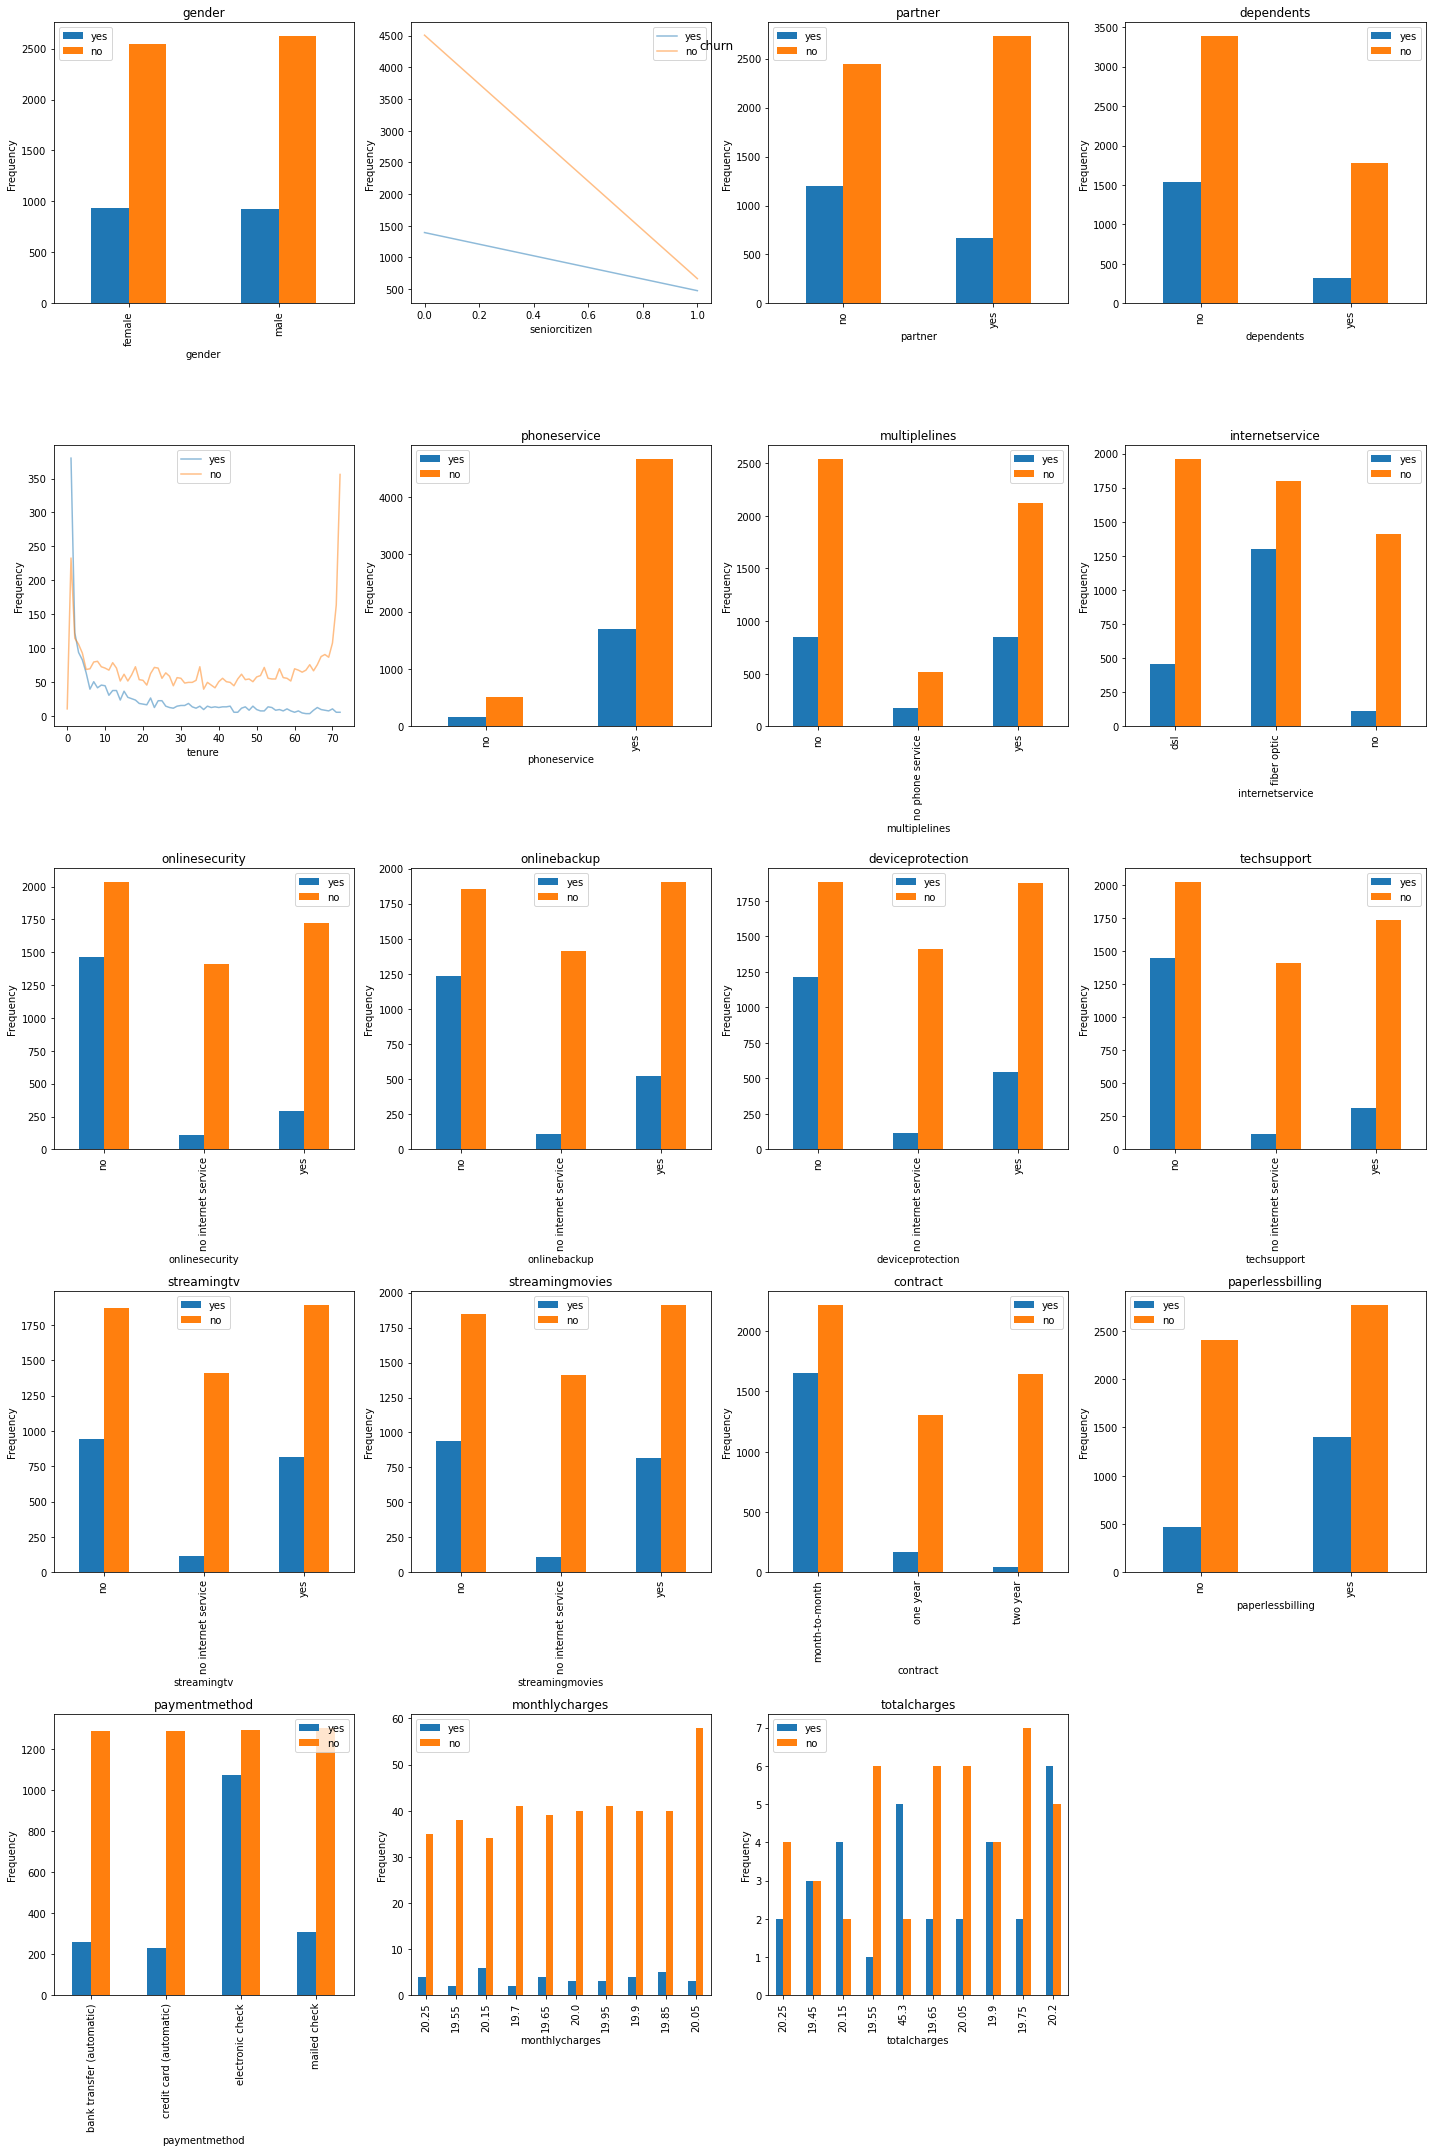

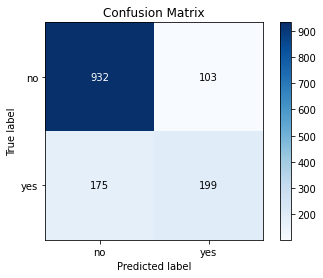

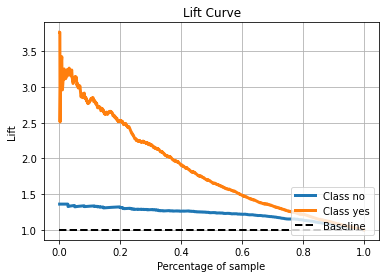

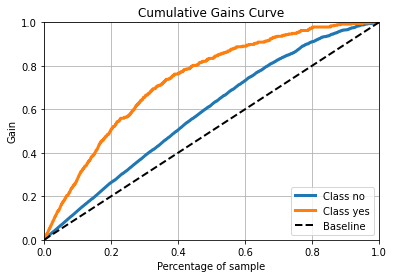

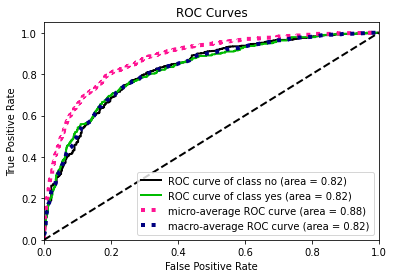

In [47]:
try:
    if isinstance(df,pd.DataFrame):
        ################## TRAINING INIT ##################
        init_info,validation = INIT(df)
        ################## TRAINING INIT ##################    

        if isinstance(validation,pd.DataFrame):
            ################## VALIDATION AND PREDICTION ##################
            validate(validation,init_info)
            ################## VALIDATION AND PREDICTION ##################
            print('\n\t #### CODE EXECUTED SUCCESSFULLY ####')
            print('\n\t #### END ####')
except KeyboardInterrupt:
    print('QUITTING!')

**Preview**

In [ ]:
# View Preview Here
pd.read_csv('preview.csv')

# Model Information

In [ ]:
joblib.load('model_info')

In [ ]:
# a = joblib.load('X.pkl')
# b = joblib.load('y.pkl')

In [ ]:
# validate(validation,init_info)

In [ ]:
# m = joblib.load('best_info')